Project1

In [1]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import wavfile
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import winsound

from keras.models import Sequential,Input,Model
from keras.layers import Conv2D,Conv1D,MaxPooling2D,AveragePooling1D
from keras.layers import Dense,Flatten
from keras import initializers,optimizers,backend as k
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [22]:
#Control on the frequencies of the wav files of the dataset
frequencies = {}
signal_lengths = {}
folders = os.listdir('./audio_files')
for folder in tqdm(folders):
    entries = os.listdir('./audio_files'+'/'+folder)
    for entry in entries:    
        fs, signal = wavfile.read('./audio_files'+'/'+folder+'/'+entry)
        if len(signal) in signal_lengths:
            signal_lengths[len(signal)]+=1
        else:
            signal_lengths[len(signal)]=1
        if fs in frequencies.keys():
            frequencies[fs]+=1
        else:
            frequencies[fs]=1

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [01:06<00:02,  2.40s/it]C:\Users\Fede\AppData\Roaming\Python\Python36\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:06<00:00,  2.14s/it]


In [23]:
x = []
y = []
for i in signal_lengths:
    x.append(i)
    y.append(signal_lengths[i])
tot = 0
for i in range(81):
    tot = tot + y[i]
freq = []
counts = []
for j in frequencies:
    freq.append(str(j)+'Hz')
    counts.append(frequencies[j])
        
labels = []
values = []
one_second = 0
less = 0
more = 0

for i in range(len(x)):
    if x[i]==16000:
        one_second+=y[i]
    elif x[i]<16000:
        less+=y[i]
    else:
        more+=y[i]
labels.append('=1 second')
values.append(one_second/tot*100)
labels.append('<1 second')
values.append(less/tot*100)
labels.append('>1 second')
values.append(more/tot*100)
fig = make_subplots(rows=1, cols=2,specs=[[{"type": "domain"},{"type": "domain"}]],
                    subplot_titles=['Duration .wav files', 'Frequency .wav files'])
fig.add_trace(go.Pie(labels=labels, values=values),row=1,col=1)
fig.add_trace(go.Pie(labels=freq, values=counts),row=1,col=2)
fig.update_layout(height=400, width=700)
fig.show()

In [24]:
def creation_filterbank(fs,signal):
        frame_size = 0.025 #duration of a frame [s]
        frame_stride = 0.01 #duration of the overlap between 2 consecutive frames [s]
        frame_length, frame_step = frame_size*fs, frame_stride*fs
        signal_length = len(signal)
        frame_length = int(round(frame_length))
        frame_step = int(round(frame_step))
        num_frames = int(np.ceil(float(np.abs(signal_length-frame_length))/frame_step))
        NFFT=400
        
        pad_signal_length = num_frames*frame_step+frame_length
        z = np.zeros((pad_signal_length-signal_length))
        pad_signal = np.append(signal,z)
        
        indices = np.tile(np.arange(0,frame_length),(num_frames,1))+np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32,copy=False)]
        frames *= np.hamming(frame_length)
        
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
        pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
        
        nfilt=40
        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)# Equally spaced in Mel scale
        hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
        bin = np.floor((NFFT + 1) * hz_points / fs)
        
       
        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # left
            f_m = int(bin[m])             # center
            f_m_plus = int(bin[m + 1])    # right

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
        filter_banks = 20 * np.log10(filter_banks)
        filter_banks -= (np.mean(filter_banks,axis=0)+1e-8)
        return filter_banks,len(signal)

In [25]:
folders = os.listdir('./audio_files')
classes = 0 #iterator for the classes
words_name = [] #list containing names of the classes
class_samples = [] #vector containing number of samples for each class
#of the training set

dataset1 = [] #training set
dataset2 = [] #validation set
dataset3 = [] #test set
output1 = [] #labels of the training set
output2 = [] #labels of the validation set
output3 = [] #labels of the test set
with open('validation_list.txt') as f:
    validation_list = f.readlines()
with open('testing_list.txt') as g:
    testing_list = g.readlines()

for folder in tqdm(folders):
    entries = os.listdir('./audio_files'+'/'+folder)
    for entry in entries:
        inserted = False
        fs, signal = wavfile.read('./audio_files'+'/'+folder+'/'+entry)
        filter_banks,length=creation_filterbank(fs,signal)
        for i in validation_list:
            if ''+folder+'/'+entry==i[0:len(folder+'/'+entry)]:
                dataset2.append(filter_banks)
                output2.append(classes)
                inserted=True
                if len(words_name)>0:
                    if words_name[-1]!=folder:
                        words_name.append(folder)
                else:
                    words_name.append(folder)
        if inserted==False:            
            for i in testing_list:
                if folder+'/'+entry==i[0:len(folder+'/'+entry)]:
                    dataset3.append(filter_banks)
                    output3.append(classes)
                    inserted = True
                    if len(words_name)>0:
                        if words_name[-1]!=folder:
                            words_name.append(folder)
                    else:
                        words_name.append(folder)
        if inserted==False:
            dataset1.append(filter_banks)
            output1.append(classes)
            if len(words_name)>0:
                if words_name[-1]!=folder:
                    words_name.append(folder)
                    class_samples.append(1)
                else:
                    class_samples[classes]+=1
            else:
                words_name.append(folder)
                class_samples.append(1)
    classes=classes+1

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [12:06<00:00, 16.55s/it]


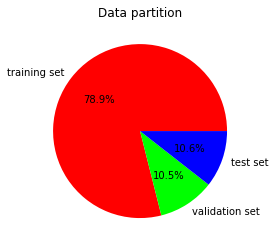

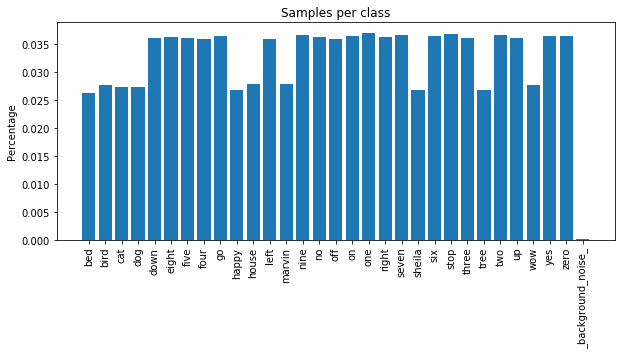

In [26]:
tot = np.sum(class_samples)
class_samples/=tot
labels = ['training set','validation set','test set']
colors = [[1,0,0],[0,1,0],[0,0,1]]
x=[len(dataset1),len(dataset2),len(dataset3)]

plt.figure()
plt.pie(x,labels=labels, autopct='%1.1f%%',colors=colors)
plt.title('Data partition')
plt.show()

plt.figure(figsize=(10,4))
plt.bar(words_name,class_samples)
plt.title('Samples per class')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()

<Figure size 432x288 with 0 Axes>

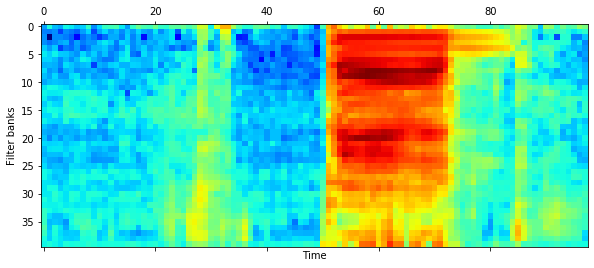

In [27]:
j = 0
plt.figure()
plt.matshow(dataset1[j].T,cmap=plt.cm.jet)
plt.xlabel('Time')
plt.ylabel('Filter banks')
plt.show()

In [ ]:
training_samples=0
validation_samples=0
test_samples=0
for i in tqdm(range(len(dataset1))):
    if dataset1[i].shape[0]==98 and dataset1[i].shape[1]==40:
        training_samples+=1
for i in tqdm(range(len(dataset2))):
    if dataset2[i].shape[0]==98 and dataset2[i].shape[1]==40:
        validation_samples+=1
for i in tqdm(range(len(dataset3))):
    if dataset3[i].shape[0]==98 and dataset3[i].shape[1]==40:
        test_samples+=1
training_set = np.zeros((training_samples,40,98))
training_labels = np.zeros((training_samples,classes))
validation_set = np.zeros((validation_samples,40,98))
validation_labels = np.zeros((validation_samples,classes))
test_set=np.zeros((test_samples,40,98))
test_labels=np.zeros((test_samples,classes))
j=0
for i in tqdm(range(len(dataset1))):
        if dataset1[i].shape[0]==98 and dataset1[i].shape[1]==40:
            training_set[j]=dataset1[i].T
            training_labels[j,output1[i]]=1
            j+=1
j=0
for i in tqdm(range(len(dataset2))):
        if dataset2[i].shape[0]==98 and dataset2[i].shape[1]==40:
            validation_set[j]=dataset2[i].T
            validation_labels[j,output2[i]]=1
            j+=1
j=0
for i in tqdm(range(len(dataset3))):
        if dataset3[i].shape[0]==98 and dataset3[i].shape[1]==40:
            test_set[j]=dataset3[i].T
            test_labels[j,output3[i]]=1
            j+=1 
np.save('training_set',training_set)
np.save('validation_set',validation_set)
np.save('training_labels',training_labels)
np.save('validation_labels',validation_labels)
np.save('test_set',test_set)
np.save('test_labels',test_labels)
np.save('words_name',words_name)

Part2 - Neural Network

In [13]:
training_set=np.load('training_set.npy')
validation_set=np.load('validation_set.npy')
training_labels=np.load('training_labels.npy')
validation_labels=np.load('validation_labels.npy')
test_set=np.load('test_set.npy')
test_labels=np.load('test_labels.npy')
words_name=np.load('words_name.npy')
training_set = training_set.reshape((-1,40,98,1))
validation_set = validation_set.reshape((-1,40,98,1))
training_loss = []
validation_loss = []

def Classifier(i):
    x = Input(shape=(40,98,1))
    x1 = (Conv2D(2**(i%3+2),kernel_size=(40,4),activation='relu'))(x)
    x2 = (Conv2D(2**(int(i/3)+2),kernel_size=(1,4),activation='relu'))(x1)
    y1 = Flatten()(x2)
    y = (Dense(31,activation='softmax'))(y1)
    classifier=Model(inputs=x,outputs=y)
    classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return classifier
    
j = 9
for i in tqdm(range(j)):
    classifier=Classifier(i)
    history=classifier.fit(training_set,training_labels,
                           validation_data=[validation_set,validation_labels],
                           epochs=20,batch_size=30,verbose=0)
    training_loss.append(history.history['acc'])
    validation_loss.append(history.history['val_acc'])

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [34:45<00:00, 240.81s/it]


[[4, 4], [8, 4], [16, 4], [4, 8], [8, 8], [16, 8], [4, 16], [8, 16], [16, 16]]


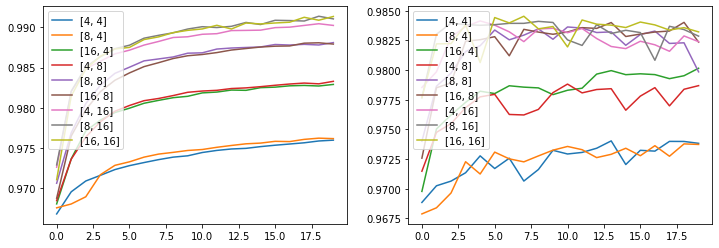

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
for i in range(j):
    ax[0].plot(training_loss[i])
    ax[1].plot(validation_loss[i]) 
legenda = []
for j in range(3):
    for i in range(3):
        legenda.append([2**(i+2),2**(j+2)])

ax[0].legend(legenda, loc='upper left')
ax[1].legend(legenda, loc='upper left')
plt.show()

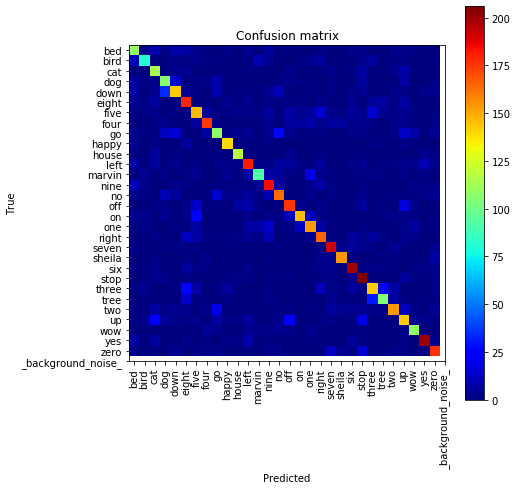

In [15]:
test_set = test_set.reshape(-1,40,98,1)
predictions = classifier.predict(test_set)
new_test_labels = np.zeros(test_labels.shape[0])

for i in range(test_labels.shape[0]):
    new_test_labels[i]=np.argmax(test_labels[i])
y_pred = np.zeros(test_labels.shape[0])

for i in range(test_labels.shape[0]):
    y_pred[i]=np.argmax(predictions[i])

cm = confusion_matrix(y_true=new_test_labels,y_pred=y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm,interpolation='nearest',cmap=plt.cm.jet)
plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(31)
plt.xticks(tick_marks,words_name,rotation=90)
plt.yticks(tick_marks,words_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

bird


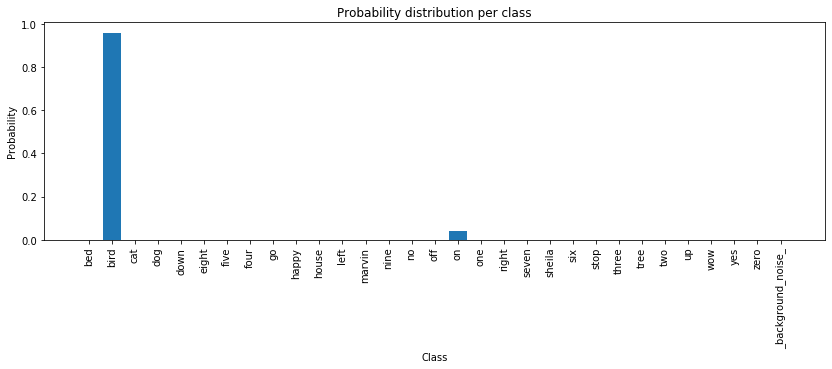

In [21]:
fs, signal = wavfile.read('./audio_files/bird/00b01445_nohash_0.wav')
winsound.PlaySound('./audio_files/bird/00b01445_nohash_0', winsound.SND_FILENAME)
filter_bank,length=creation_filterbank(fs,signal)
audio_signal=np.zeros((1,40,98,1))
audio_signal[0,:,:,0]=filter_bank.T

print (words_name[np.argmax(classifier.predict(audio_signal))])

plt.figure(figsize=(14,4))
plt.bar(words_name,classifier.predict(audio_signal)[0])
plt.title('Probability distribution per class')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=90)
plt.show()